In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls /content/gdrive/My\ Drive/eva-04/S11/* 

We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/eva-04/S11/')

Now we can import the library and use the function.

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensor
from models import ResnetA11 as resnetA11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnetA11)
importlib.reload(cifar)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnetA11.ResNetA11().to(device)

SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(g_train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(g_test, **dataloader_args)
#import images as im
#import random
#X,Y,names = im.get_data('cifar-10-batches-py/data_batch_1')
import numpy as np
import matplotlib.pyplot as plt
import os
#importlib.reload(im)
#for x in range(100):
#  im.visualize_image(X,Y,names,random.randint(1,10000),'/content/gdrive/My Drive/eva-04/S9/images')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda
CUDA Available? True


SHOW PARAMETERS

In [4]:
from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import ResnetA11 as resnet_a11
from transformations import CIFARModel11_Alb as cifar

import importlib
importlib.reload(resnet_a11)
importlib.reload(cifar)
importlib.reload(fun) 
from torch.optim.lr_scheduler import OneCycleLR
criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0003)
scheduler = OneCycleLR(optimizer, max_lr=0.3, steps_per_epoch=196, epochs=25,final_div_factor=1,last_epoch =-1)
cifar_model = cifar.CIFARModel11_Alb(model,criterion,optimizer,scheduler)
show_summary(cifar_model,input_size=(3,32,32))


Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13       

LRFinder

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


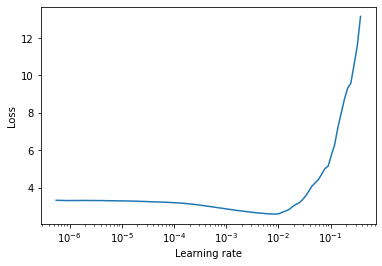

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

#model1 = resnet_a11.ResNetA11().to(device)
#criterion1 = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=200, num_iter=150, step_mode="exp")
#model = rc10.resnet56()
#lr_finder = LRFinder(model,cifar_model.m_optimizer,cifar_model.m_criterion, device)
#lr_finder.range_test(cifar_model.m_trainloader, end_lr=100, num_iter=100, step_mode="exp")
#lr_finder.range_test(cifar_model.m_train_loader, val_loader=cifar_model.m_test_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot(skip_end=0)
lr_finder.reset()

DRAW CyclicLR PLOT

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def draw_cyclic_lr_graph(lr_min,lr_max,step,iterations):
  #lr_min,lr_max are in y direction
  # each triangle to be plot with 3 points (0,lr_min),(0+step,lr_max),(2*step,lr_max) 
  x_points = [0]
  y_points = [lr_min]
  last_step=step
  max = True
  plt.figure(figsize=(20,10))
  
  for x in range(iterations):
    x_points.append(last_step)
    last_step= last_step + step
    if(max == True):
      y_points.append(lr_max)
      max = False
    else:
      y_points.append(lr_min)
      max = True
  #for i in range(iterations-1):
    plt.plot(x_points, y_points, 'bo-')
    #print(x_points[i],'::',y_points[i])
  
  plt.xlabel('Iterations')
  plt.ylabel('Lr Range')
  plt.show()


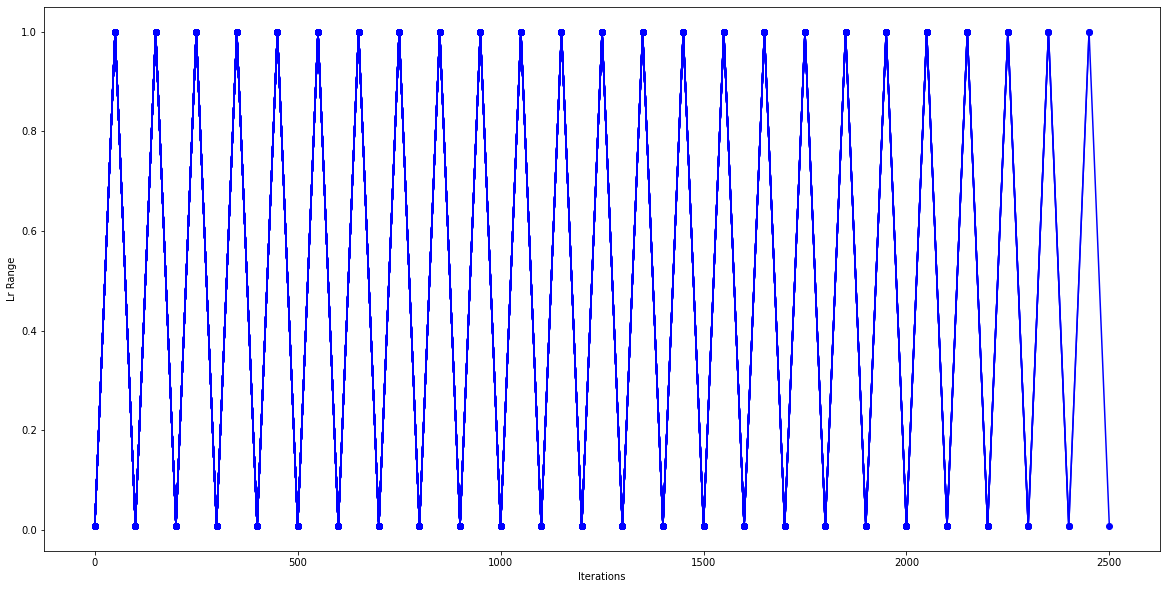

In [9]:
draw_cyclic_lr_graph(0.007,1,50,50)

RUNNING WITH REGULARIZATION

In [5]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=1, LAMBDA=0.0005, EPOCHS=5)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=2.7921433448791504 Batch_id=97 Accuracy=12.03: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 1048/10000 (10.48%)

EPOCH: 1
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=2.4297735691070557 Batch_id=97 Accuracy=17.24: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 2222/10000 (22.22%)

EPOCH: 2
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=2.1421561241149902 Batch_id=97 Accuracy=23.66: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 2771/10000 (27.71%)

EPOCH: 3
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=2.063689708709717 Batch_id=97 Accuracy=26.32: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 3111/10000 (31.11%)

EPOCH: 4
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=2.080469846725464 Batch_id=97 Accuracy=28.97: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]



Test set: Average loss: 0.0042, Accuracy: 3254/10000 (32.54%)

0.01200000000000001


In [6]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=1, LAMBDA=0.0005, EPOCHS=20,start=5)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 5
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=2.1400678157806396 Batch_id=97 Accuracy=31.83: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 3725/10000 (37.25%)

EPOCH: 6
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=1.9336638450622559 Batch_id=97 Accuracy=32.11: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 3597/10000 (35.97%)

EPOCH: 7
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=1.7725632190704346 Batch_id=97 Accuracy=35.66: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4100/10000 (41.00%)

EPOCH: 8
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 4228/10000 (42.28%)

EPOCH: 9
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=1.7566653490066528 Batch_id=97 Accuracy=40.34: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4506/10000 (45.06%)

EPOCH: 10
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=1.6743448972702026 Batch_id=97 Accuracy=41.93: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4670/10000 (46.70%)

EPOCH: 11
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=1.5794283151626587 Batch_id=97 Accuracy=42.87: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4783/10000 (47.83%)

EPOCH: 12
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=1.6464594602584839 Batch_id=97 Accuracy=45.67: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 4808/10000 (48.08%)

EPOCH: 13
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=1.5516908168792725 Batch_id=97 Accuracy=47.29: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5391/10000 (53.91%)

EPOCH: 14
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=1.4914495944976807 Batch_id=97 Accuracy=49.04: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 5239/10000 (52.39%)

EPOCH: 15
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=1.427923321723938 Batch_id=97 Accuracy=51.19: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5745/10000 (57.45%)

EPOCH: 16
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=1.2734966278076172 Batch_id=97 Accuracy=52.60: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6101/10000 (61.01%)

EPOCH: 17
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=1.2977485656738281 Batch_id=97 Accuracy=54.25: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6250/10000 (62.50%)

EPOCH: 18
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=1.311105489730835 Batch_id=97 Accuracy=56.10: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6358/10000 (63.58%)

EPOCH: 19
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=1.2165374755859375 Batch_id=97 Accuracy=57.24: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6502/10000 (65.02%)

EPOCH: 20
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=1.0603406429290771 Batch_id=97 Accuracy=58.94: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6651/10000 (66.51%)

EPOCH: 21
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=1.1241697072982788 Batch_id=97 Accuracy=60.57: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6874/10000 (68.74%)

EPOCH: 22
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=1.0827085971832275 Batch_id=97 Accuracy=62.03: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 6941/10000 (69.41%)

EPOCH: 23
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=1.1150438785552979 Batch_id=97 Accuracy=62.00: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6869/10000 (68.69%)

EPOCH: 24
L1= 1 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=1.0837053060531616 Batch_id=97 Accuracy=63.32: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]



Test set: Average loss: 0.0018, Accuracy: 6970/10000 (69.70%)

0.01200000000000001


In [7]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=0, LAMBDA=0.0005, EPOCHS=20,start=25)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 25
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=1.011382818222046 Batch_id=97 Accuracy=64.42: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7123/10000 (71.23%)

EPOCH: 26
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=0.9985995292663574 Batch_id=97 Accuracy=65.74: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7375/10000 (73.75%)

EPOCH: 27
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=0.9669876098632812 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7420/10000 (74.20%)

EPOCH: 28
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=0.8378203511238098 Batch_id=97 Accuracy=66.61: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7134/10000 (71.34%)

EPOCH: 29
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=0.9491205811500549 Batch_id=97 Accuracy=67.64: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7615/10000 (76.15%)

EPOCH: 30
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=1.0683813095092773 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7559/10000 (75.59%)

EPOCH: 31
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=0.9068402647972107 Batch_id=97 Accuracy=68.75: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7540/10000 (75.40%)

EPOCH: 32
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=0.7828189134597778 Batch_id=97 Accuracy=69.81: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7634/10000 (76.34%)

EPOCH: 33
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=0.9066754579544067 Batch_id=97 Accuracy=70.14: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7647/10000 (76.47%)

EPOCH: 34
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=0.8023115992546082 Batch_id=97 Accuracy=70.97: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7626/10000 (76.26%)

EPOCH: 35
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=0.7937070727348328 Batch_id=97 Accuracy=71.26: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7706/10000 (77.06%)

EPOCH: 36
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=0.8049638867378235 Batch_id=97 Accuracy=71.37: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7774/10000 (77.74%)

EPOCH: 37
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=0.7366657257080078 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7807/10000 (78.07%)

EPOCH: 38
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=0.8449814319610596 Batch_id=97 Accuracy=72.60: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7977/10000 (79.77%)

EPOCH: 39
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=0.7505054473876953 Batch_id=97 Accuracy=73.49: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7959/10000 (79.59%)

EPOCH: 40
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=0.9050851464271545 Batch_id=97 Accuracy=73.68: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7809/10000 (78.09%)

EPOCH: 41
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=0.8280547857284546 Batch_id=97 Accuracy=74.23: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7915/10000 (79.15%)

EPOCH: 42
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=0.8675041198730469 Batch_id=97 Accuracy=74.35: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7994/10000 (79.94%)

EPOCH: 43
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=0.7303752899169922 Batch_id=97 Accuracy=75.50: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8170/10000 (81.70%)

EPOCH: 44
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=0.7036100029945374 Batch_id=97 Accuracy=75.26: 100%|██████████| 98/98 [00:29<00:00,  3.38it/s]



Test set: Average loss: 0.0011, Accuracy: 8164/10000 (81.64%)

0.01200000000000001


In [8]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=0, LAMBDA=0.0005, EPOCHS=20,start=35)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 35
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=0.6676074862480164 Batch_id=97 Accuracy=76.16: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8118/10000 (81.18%)

EPOCH: 36
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=0.7948852777481079 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [00:29<00:00,  3.28it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7950/10000 (79.50%)

EPOCH: 37
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=0.7357573509216309 Batch_id=97 Accuracy=75.73: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8106/10000 (81.06%)

EPOCH: 38
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=0.6431818604469299 Batch_id=97 Accuracy=76.55: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8276/10000 (82.76%)

EPOCH: 39
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=0.6317871809005737 Batch_id=97 Accuracy=77.25: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8111/10000 (81.11%)

EPOCH: 40
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=0.6823016405105591 Batch_id=97 Accuracy=77.52: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8195/10000 (81.95%)

EPOCH: 41
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=0.6755287051200867 Batch_id=97 Accuracy=78.03: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8235/10000 (82.35%)

EPOCH: 42
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=0.6175021529197693 Batch_id=97 Accuracy=78.19: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8090/10000 (80.90%)

EPOCH: 43
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=0.6594176888465881 Batch_id=97 Accuracy=78.28: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8287/10000 (82.87%)

EPOCH: 44
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=0.5451951026916504 Batch_id=97 Accuracy=78.79: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8320/10000 (83.20%)

EPOCH: 45
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=0.7029289603233337 Batch_id=97 Accuracy=78.85: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8386/10000 (83.86%)

EPOCH: 46
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=0.5239580273628235 Batch_id=97 Accuracy=79.23: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8308/10000 (83.08%)

EPOCH: 47
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=0.6082370281219482 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8375/10000 (83.75%)

EPOCH: 48
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=0.6423926949501038 Batch_id=97 Accuracy=80.01: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8317/10000 (83.17%)

EPOCH: 49
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=0.581933856010437 Batch_id=97 Accuracy=80.37: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8303/10000 (83.03%)

EPOCH: 50
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=0.5681532621383667 Batch_id=97 Accuracy=80.57: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8438/10000 (84.38%)

EPOCH: 51
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=0.45547565817832947 Batch_id=97 Accuracy=81.13: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8546/10000 (85.46%)

EPOCH: 52
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=0.5014541149139404 Batch_id=97 Accuracy=81.25: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8386/10000 (83.86%)

EPOCH: 53
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=0.528899610042572 Batch_id=97 Accuracy=81.30: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8426/10000 (84.26%)

EPOCH: 54
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=0.49081456661224365 Batch_id=97 Accuracy=81.70: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Average loss: 0.0009, Accuracy: 8470/10000 (84.70%)

0.01200000000000001


In [9]:
run_model_with_entropy(cifar_model, device, doL1= 0, doL2=0, LAMBDA=0.0005, EPOCHS=20,start=55)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 55
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=0.580249547958374 Batch_id=97 Accuracy=81.78: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8475/10000 (84.75%)

EPOCH: 56
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=0.4923763871192932 Batch_id=97 Accuracy=81.45: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8418/10000 (84.18%)

EPOCH: 57
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=0.5616950988769531 Batch_id=97 Accuracy=82.63: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8488/10000 (84.88%)

EPOCH: 58
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=0.5226879119873047 Batch_id=97 Accuracy=82.47: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8441/10000 (84.41%)

EPOCH: 59
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=0.5798095464706421 Batch_id=97 Accuracy=82.62: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8570/10000 (85.70%)

EPOCH: 60
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=0.536646842956543 Batch_id=97 Accuracy=82.79: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8542/10000 (85.42%)

EPOCH: 61
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=0.4666629135608673 Batch_id=97 Accuracy=82.46: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8433/10000 (84.33%)

EPOCH: 62
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=0.4467925429344177 Batch_id=97 Accuracy=83.48: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8592/10000 (85.92%)

EPOCH: 63
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=0.5593134760856628 Batch_id=97 Accuracy=83.30: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8553/10000 (85.53%)

EPOCH: 64
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=0.4226796329021454 Batch_id=97 Accuracy=83.89: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8472/10000 (84.72%)

EPOCH: 65
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=0.5448662638664246 Batch_id=97 Accuracy=83.85: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8651/10000 (86.51%)

EPOCH: 66
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=0.44126051664352417 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8547/10000 (85.47%)

EPOCH: 67
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=0.5743285417556763 Batch_id=97 Accuracy=84.31: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 68
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=0.40565308928489685 Batch_id=97 Accuracy=84.63: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8620/10000 (86.20%)

EPOCH: 69
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=0.4916978180408478 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8650/10000 (86.50%)

EPOCH: 70
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=0.4290030300617218 Batch_id=97 Accuracy=84.64: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8578/10000 (85.78%)

EPOCH: 71
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=0.397011935710907 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8677/10000 (86.77%)

EPOCH: 72
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=0.4705476760864258 Batch_id=97 Accuracy=84.81: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8738/10000 (87.38%)

EPOCH: 73
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=0.3538861572742462 Batch_id=97 Accuracy=85.31: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 74
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=0.43461790680885315 Batch_id=97 Accuracy=85.38: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.0008, Accuracy: 8769/10000 (87.69%)

0.01200000000000001


In [10]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=0, LAMBDA=0.0005, EPOCHS=20,start=75)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 75
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 0


Loss=0.40954717993736267 Batch_id=97 Accuracy=85.11: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8541/10000 (85.41%)

EPOCH: 76
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 1


Loss=0.44535183906555176 Batch_id=97 Accuracy=85.65: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8714/10000 (87.14%)

EPOCH: 77
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 2


Loss=0.42578062415122986 Batch_id=97 Accuracy=85.95: 100%|██████████| 98/98 [00:29<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8742/10000 (87.42%)

EPOCH: 78
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 3


Loss=0.38229820132255554 Batch_id=97 Accuracy=85.85: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8663/10000 (86.63%)

EPOCH: 79
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 4


Loss=0.41573143005371094 Batch_id=97 Accuracy=85.80: 100%|██████████| 98/98 [00:29<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8716/10000 (87.16%)

EPOCH: 80
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 5


Loss=0.3744698762893677 Batch_id=97 Accuracy=86.44: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8694/10000 (86.94%)

EPOCH: 81
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 6


Loss=0.388704389333725 Batch_id=97 Accuracy=86.44: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8512/10000 (85.12%)

EPOCH: 82
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 7


Loss=0.45891842246055603 Batch_id=97 Accuracy=86.12: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8678/10000 (86.78%)

EPOCH: 83
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 8


Loss=0.3016286790370941 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8662/10000 (86.62%)

EPOCH: 84
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 9


Loss=0.3881194293498993 Batch_id=97 Accuracy=86.42: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8627/10000 (86.27%)

EPOCH: 85
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 10


Loss=0.3990660607814789 Batch_id=97 Accuracy=86.78: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8712/10000 (87.12%)

EPOCH: 86
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 11


Loss=0.2967624068260193 Batch_id=97 Accuracy=87.13: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8706/10000 (87.06%)

EPOCH: 87
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 12


Loss=0.37376436591148376 Batch_id=97 Accuracy=87.34: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8729/10000 (87.29%)

EPOCH: 88
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 13


Loss=0.32148829102516174 Batch_id=97 Accuracy=87.07: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8672/10000 (86.72%)

EPOCH: 89
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 14


Loss=0.3586171865463257 Batch_id=97 Accuracy=87.44: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8824/10000 (88.24%)

EPOCH: 90
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 15


Loss=0.35941988229751587 Batch_id=97 Accuracy=87.39: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8757/10000 (87.57%)

EPOCH: 91
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 16


Loss=0.3762349486351013 Batch_id=97 Accuracy=87.51: 100%|██████████| 98/98 [00:29<00:00,  3.34it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8658/10000 (86.58%)

EPOCH: 92
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 17


Loss=0.36797866225242615 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8839/10000 (88.39%)

EPOCH: 93
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 18


Loss=0.46078822016716003 Batch_id=97 Accuracy=88.03: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8738/10000 (87.38%)

EPOCH: 94
L1= 0 ;L2= 0.0005 ;LAMBDA= 0 epoch= 19


Loss=0.4102996587753296 Batch_id=97 Accuracy=87.75: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.0008, Accuracy: 8740/10000 (87.40%)

0.01200000000000001


Training and Validation Accuracy Change

0  and  105


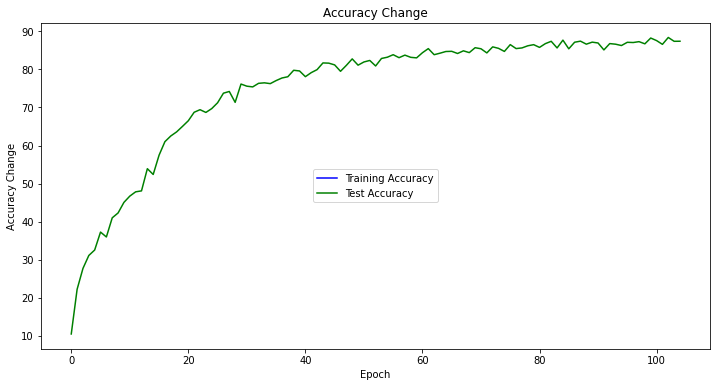

In [11]:

import utils.global_fun as fun
importlib.reload(fun)

importlib.reload(fun)
from utils.global_fun import plot_accuracy_loss_graphs, draw_accuracy_graph
print(len(cifar_model.m_train_acc),' and ',len(cifar_model.m_test_acc))
draw_accuracy_graph(cifar_model,'Accuracy Change')

SAVE MODEL

In [0]:
state = {
    'epoch': 150,
    'state_dict': cifar_model.m_model.state_dict(),
    'optimizer': cifar_model.m_optimizer.state_dict()
}

filepath = "/content/gdrive/My Drive/eva-04/S11/saved_model"

torch.save(cifar_model.m_model.state_dict(), open(os.path.join(filepath, 'model.pt'), 'wb'))
torch.save(cifar_model.m_optimizer.state_dict(), open(os.path.join(filepath, 'optimizer.pt'), 'wb'))
torch.save(state, open(os.path.join(filepath, 'savedmodel'), 'wb'))

#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
#model = torch.load(filepath)


LR FINDER

Increases the learning rate in an exponential manner and computes the training loss for each learning rate. lr_finder.plot() plots the training loss versus logarithmic learning rate.

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


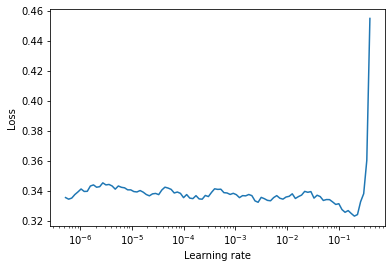

In [12]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

model = resnet_a11.ResNetA11().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")
lr_finder.plot()

lr_finder.reset()

#model = rc10.resnet56()
#lr_finder = LRFinder(model,cifar_model.m_optimizer,cifar_model.m_criterion, device)
#lr_finder.range_test(cifar_model.m_trainloader, end_lr=100, num_iter=100, step_mode="exp")


GRADCAM VISUALIZATION

In [0]:

def plot_gradcam(cam_data, pred_data, classes, plot_name):
    fig, axs = plt.subplots(len(cam_data), 2, figsize=(4, 60))

    for idx in range(len(cam_data)):
        label = classes[pred_data[idx]['label']]
        prediction = classes[pred_data[idx]['prediction']]

        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx + 1}\nLabel: {label}')
        axs[idx][0].imshow(cam_data[idx]['image'])

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'GradCAM: {idx + 1}\nPrediction: {prediction}')
        axs[idx][1].imshow(cam_data[idx]['result']['layer3'])
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)
    fig.savefig(plot_name, bbox_inches='tight')

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


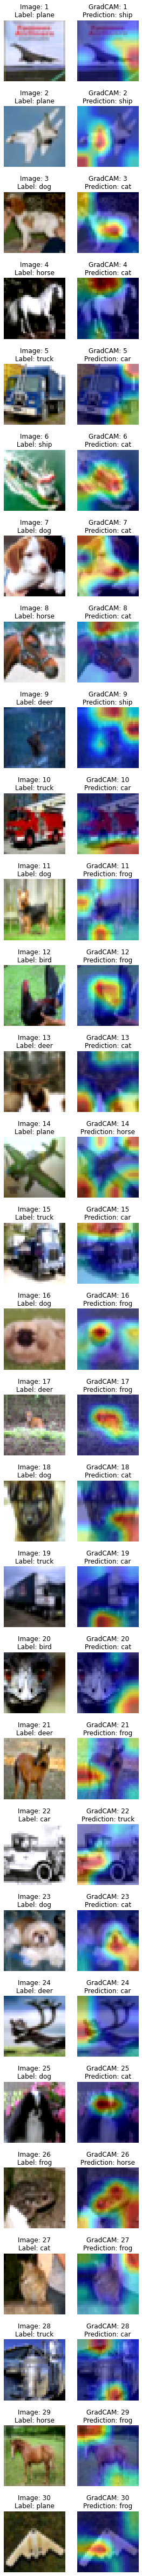

In [21]:
from gradcam import visualize as vs

layers = ['layer3']
grad_cam = vs.GradCAMView(
    cifar_model.m_model, layers,
    device, cifar.mean(), cifar.std()
)

from gradcam import visualize as vs 
importlib.reload(vs)

views = grad_cam([x['image'] for x in cifar_model.m_incorrect_samples])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(views, cifar_model.m_incorrect_samples, classes, 'prediction_gradcam.png')